# **0. Importing libraries**

Import helper functions

In [29]:
import sys
sys.path.append('/Users/jorissoolsma/Desktop/Programming/Helpers')
from combinations import count_presence_combinations
import joblib
import numpy


Import libraries

In [30]:
# region Data Libraries
import pandas as pd
import geopandas as gpd
import numpy as np
# endregion

# region Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# endregion

# region Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import contextily as ctx
import folium
from folium.plugins import MarkerCluster
# endregion

# region Fuzzy Matching
from thefuzz import fuzz, process
from rapidfuzz import fuzz
# endregion

# region Date and Time
import datetime
from datetime import datetime
# endregion

# region Utilities
import re
from collections import Counter, defaultdict
import importlib
# endregion

import joblib

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE

import shap

from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import numpy as np

import numpy as np
import pandas as pd
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt




# **1. Reading files & Merging files**

#### BRON

In [16]:
import pandas as pd
import geopandas as gpd

# -- Region: Load and Prepare Accident Data (2017–2020) --

accident_cols = ['VKL_NUMMER', 'JAAR_VKL', 'AP3_CODE', 'ANTL_PTJ', 'AOL_ID', 'NIVEAUKOP', 'WSE_ID',
                 'BEBKOM', 'MAXSNELHD', 'WVL_ID', 'WVG_ID', 'WVG_AN', 'WDK_ID', 'LGD_ID', 'WGD_CODE_1',
                 'WGD_CODE_2', 'BZD_ID_VM1', 'BZD_ID_IF1', 'BZD_IF_AN', 'BZD_ID_TA1', 'BZD_TA_AN',
                 'JTE_ID', 'WVK_ID', 'FK_VELD5', 'GME_ID', 'GME_NAAM', 'PVE_CODE', 'PVE_NAAM']

# Read accident data for 2017–2020
accidents = {}
for year in range(2017, 2021):
    path = f"/Users/jorissoolsma/Downloads/01-01-{year}_31-12-{year}/Ongevallengegevens/ongevallen.txt"
    accidents[year] = pd.read_csv(path, sep=',', encoding='latin1', usecols=accident_cols)

# Read location data for 2017–2020
locations = {}
for year in range(2017, 2021):
    path = f"/Users/jorissoolsma/Downloads/01-01-{year}_31-12-{year}/Netwerkgegevens/puntlocaties.txt"
    df = pd.read_csv(path)
    locations[year] = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['X_COORD'], df['Y_COORD']), crs="EPSG:28992")

# Merge accidents with location data
merged = {year: accidents[year].merge(locations[year], on='FK_VELD5') for year in range(2017, 2021)}

# -- Region: Load and Prepare 2021–2023 Data --
print('X')
def load_recent_year(year):
    location_path = f"/Users/jorissoolsma/Desktop/Programming/Datasets/BRON Puntlocatie's/puntlocaties{year}.txt"
    accident_path = f"/Users/jorissoolsma/Desktop/Programming/Datasets/BRON Ongevallen/ongevallen{year}.txt"
    
    df_loca = pd.read_csv(location_path)
    gdf_loca = gpd.GeoDataFrame(df_loca, geometry=gpd.points_from_xy(df_loca['X_COORD'], df_loca['Y_COORD']), crs="EPSG:28992")
    
    df_acc = pd.read_csv(accident_path, sep=',', encoding='latin1', usecols=accident_cols)
    merged = df_acc.merge(gdf_loca, on='FK_VELD5')
    return merged

merged[2021] = load_recent_year(2021)
merged[2022] = load_recent_year(2022)
merged[2023] = load_recent_year(2023)

# -- Region: Combine All Years --

# Combine all years into one dataframe
all_accidents = pd.concat(list(merged.values()), ignore_index=True)

# Preview output
all_accidents.info()


/var/folders/c2/9ncptkzj657d0bp07xyq26y00000gn/T/ipykernel_44820/3908179532.py:15: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents[year] = pd.read_csv(path, sep=',', encoding='latin1', usecols=accident_cols)


X


/var/folders/c2/9ncptkzj657d0bp07xyq26y00000gn/T/ipykernel_44820/3908179532.py:36: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_acc = pd.read_csv(accident_path, sep=',', encoding='latin1', usecols=accident_cols)
/var/folders/c2/9ncptkzj657d0bp07xyq26y00000gn/T/ipykernel_44820/3908179532.py:36: DtypeWarning: Columns (29,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_acc = pd.read_csv(accident_path, sep=',', encoding='latin1', usecols=accident_cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860610 entries, 0 to 860609
Data columns (total 31 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   VKL_NUMMER  860610 non-null  int64   
 1   JAAR_VKL    860610 non-null  int64   
 2   AP3_CODE    860610 non-null  object  
 3   ANTL_PTJ    860610 non-null  int64   
 4   AOL_ID      860610 non-null  int64   
 5   NIVEAUKOP   860610 non-null  object  
 6   WSE_ID      556174 non-null  float64 
 7   BEBKOM      563350 non-null  object  
 8   MAXSNELHD   735232 non-null  float64 
 9   WVL_ID      554708 non-null  float64 
 10  WVG_ID      547828 non-null  float64 
 11  WVG_AN      4470 non-null    object  
 12  WDK_ID      560018 non-null  float64 
 13  LGD_ID      860598 non-null  float64 
 14  WGD_CODE_1  540987 non-null  object  
 15  WGD_CODE_2  751 non-null     object  
 16  BZD_ID_VM1  46931 non-null   float64 
 17  BZD_ID_IF1  29389 non-null   float64 
 18  BZD_IF_AN   64042 non-nu

#### Time features

In [17]:
# -- Step 1: Define column types and load CSV --
types = {
    'VKL_NUMMER': 'Int64',
    'DATUM_VKL': 'Int64',
    'UUR': 'object'
}

time = pd.read_csv('/Users/jorissoolsma/Desktop/Programming/Datasets/BRON time/Export_datumVKL_Uur.txt', dtype=types, na_values=None)

# -- Step 2: Fix hour formatting (pad with leading zero if needed) --
time['UUR'] = time['UUR'].apply(lambda x: f'{x:02}')

# -- Step 3: Combine date and hour into single datetime string --
time['DATUM_VKL'] = time['DATUM_VKL'].astype(str) + time['UUR']

# -- Step 4: Convert to datetime format safely --
time['DATUM_VKL'] = pd.to_datetime(time['DATUM_VKL'], format='%Y%m%d%H', errors='coerce')

# -- Step 5: Drop raw hour column --
time = time.drop(columns='UUR')

# -- Step 6: Extract datetime components --
time['Hour'] = time['DATUM_VKL'].dt.hour
time['Month'] = time['DATUM_VKL'].dt.month
time['Day'] = time['DATUM_VKL'].dt.day
time['Day_of_week'] = time['DATUM_VKL'].dt.dayofweek


In [18]:
all_accidents = all_accidents.merge(time, left_on= 'VKL_NUMMER', right_on= 'VKL_NUMMER', how = 'left')

#### Geoframe transformation

In [19]:
all_accidents = gpd.GeoDataFrame(all_accidents, geometry=gpd.points_from_xy(all_accidents['X_COORD'], all_accidents['Y_COORD']))  ### Adds a geometry column

all_accidents = all_accidents.set_crs('EPSG:28992')      # Ensures that CRS is set to the standard in the Netherlands
all_accidents.crs                                 # <Projected CRS: EPSG:28992>


<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [20]:
df_100m = all_accidents.copy()
df_100m['buffer_100m'] = df_100m.geometry.buffer(100)
df_100m = df_100m.set_geometry('buffer_100m')

#### Subset on Location accuracy

In [21]:
# Exclude accidents with non-exact x,y location (street and municipality)
location_accuracies = ['S', 'G']

# --- Filter 100m buffer ---
df_100m_filtered = df_100m[~df_100m['NIVEAUKOP'].isin(location_accuracies)].copy()



#### rename columns

In [22]:
new_column_names = {
    'VKL_NUMMER':'Accident_Id',
    'JAAR_VKL':'Year',
    'AP3_CODE':'Severity_level',
    'ANTL_PTJ': 'Nr_of_parties',
    'AOL_ID': 'Nature_of_accident',
    'NIVEAUKOP':'Location_accuracy',
    'WSE_ID': 'Road_segment_type',
    'BEBKOM':'Urban_zone',
    'MAXSNELHD':'Max_speed',
    'WVL_ID': 'Streetlight_status',
    'WVG_ID': 'Road_surface',                           ### merge with road_surface_other
    'WVG_AN': 'Road_surface_other',                     ### merge with road_surface
    'WDK_ID': 'Road_surface_condition',
    'LGD_ID': 'Natural_light',
    'WGD_CODE_1' : 'Weather_conditions_1',              ### check whether these are not the same
    'WGD_CODE_2' : 'Weather_conditions_2',              ### check whether these are not the same
    'BZD_ID_VM1' : 'Special_traffic_measure',           
    'BZD_ID_IF1' : 'Special_infrastructure',
    'BZD_IF_AN' : 'Special_infrastructure_other',       ### needs additional preprocessing
    'BZD_ID_TA1' : 'Special_temporary',
    'BZD_TA_AN' : 'Special_temporary_other',            ### needs addiitonal preprocessing, some can be used to fill features
    'JTE_ID_X': 'Junction_Id',
    'WVK_ID_X': 'Road_section_Id',
    'FK_VELD5': 'Location_id',
    'GME_ID' : 'Municipality_Id',
    'GME_NAAM': 'Municipality_name',
    'PVE_CODE' : 'Province_Id',
    'PVE_NAAM' : 'Province_name',
}

df_100m_filtered = df_100m_filtered.rename(columns=new_column_names)

#### Basisregistratie adressen en gebouwen (BAG)

In [23]:
import geopandas as gpd
import pandas as pd

# Load BAG data
bag_path = '/Users/jorissoolsma/Desktop/Programming/Datasets/BAG/bag-light.gpkg 2'
bag = gpd.read_file(bag_path, layer='pand')[['bouwjaar', 'gebruiksdoel', 'geometry']]

# Convert polygons to centroids
bag['geometry'] = bag.geometry.centroid

# Remove invalid years
bag = bag[bag['bouwjaar'] != 9999]

# Simplify gebruiksdoel
def simplify_gebruiksdoel(value):
    if pd.isna(value):
        return value
    if ',' in value:
        return 'mixed_usage'
    return value

bag['gebruiksdoel_simplified'] = bag['gebruiksdoel'].apply(simplify_gebruiksdoel)
bag = bag.drop(columns='gebruiksdoel')


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /Users/jorissoolsma/Desktop/Programming/Datasets/BAG/bag-light.gpkg 2 has GPKG application_id, but non conformant file extension
  return ogr_read(


In [24]:
def process_buffer_batches(buffers_gdf, points_gdf, buffer_col, batch_size=100, total=None):
    """
    Joins BAG points to buffer polygons in batches and aggregates counts of 'gebruiksdoel_simplified'.

    Parameters:
        buffers_gdf (GeoDataFrame): GeoDataFrame with buffer geometry (e.g., 'buffer_200m').
        points_gdf (GeoDataFrame): BAG data with 'gebruiksdoel_simplified' and point geometry.
        buffer_col (str): Name of the buffer geometry column to use.
        batch_size (int): Number of buffers per batch.
        total (int): Total number of buffers to process (optional).

    Returns:
        pd.DataFrame: Aggregated counts of usage types per buffer.
    """
    if total is None:
        total = len(buffers_gdf)

    results = []

    for start in range(0, total, batch_size):
        end = min(start + batch_size, total)
        print(f"Processing batch {start} to {end - 1}...")

        batch = buffers_gdf.iloc[start:end].copy()
        batch = batch.set_geometry(buffer_col)

        joined = gpd.sjoin(points_gdf, batch, how='inner', predicate='within')

        agg = (
            joined.groupby(['Accident_Id', 'gebruiksdoel_simplified'])
            .size()
            .unstack(fill_value=0)
            .add_suffix(f'_count_{buffer_col[-4:]}')
            .reset_index()
        )

        results.append(agg)

    return pd.concat(results, ignore_index=True)



In [25]:
bron_buffer_100m = df_100m_filtered[['Accident_Id', 'buffer_100m']].copy()
result_100m = process_buffer_batches(
    buffers_gdf=bron_buffer_100m,
    points_gdf=bag,
    buffer_col='buffer_100m',
    batch_size=100000,
    total=bron_buffer_100m.shape[0]
)

Processing batch 0 to 99999...
Processing batch 100000 to 199999...
Processing batch 200000 to 299999...
Processing batch 300000 to 399999...
Processing batch 400000 to 499999...
Processing batch 500000 to 599999...
Processing batch 600000 to 699999...
Processing batch 700000 to 724110...


In [26]:
column_translation = {
    "bijeenkomstfunctie_count_100m": "assembly_function_count_100m",
    "celfunctie_count_100m": "detention_function_count_100m",  # often refers to detention/prison cells
    "gezondheidszorgfunctie_count_100m": "healthcare_function_count_100m",
    "industriefunctie_count_100m": "industrial_function_count_100m",
    "kantoorfunctie_count_100m": "office_function_count_100m",
    "logiesfunctie_count_100m": "lodging_function_count_100m",
    "mixed_usage_count_100m": "mixed_usage_count_100m",
    "onderwijsfunctie_count_100m": "educational_function_count_100m",
    "overige gebruiksfunctie_count_100m": "other_usage_function_count_100m",
    "sportfunctie_count_100m": "sports_function_count_100m",
    "winkelfunctie_count_100m": "retail_function_count_100m",
    "woonfunctie_count_100m": "residential_function_count_100m"
}

result_100m.rename(columns= column_translation, inplace= True)

In [27]:
df_100m_merged = df_100m_filtered.merge(result_100m, on='Accident_Id', how='left')

In [31]:
joblib.dump(df_100m_merged, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/post_bag_100')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/post_bag_100']

#### BAG feature engineering building age

In [32]:
from datetime import datetime
import geopandas as gpd

def average_bouwjaar_age(buffers_gdf, points_gdf, buffer_col='buffer_100m'):
    """
    Computes the average age of buildings (based on bouwjaar) per buffer polygon.

    Parameters:
        buffers_gdf (GeoDataFrame): Contains 'Accident_Id' and buffer column (e.g. 'buffer_200m').
        points_gdf (GeoDataFrame): Contains building points with 'bouwjaar' column.
        buffer_col (str): Name of the buffer geometry column to use.

    Returns:
        pd.DataFrame: Columns: ['Accident_Id', 'average_age']
    """
    # Ensure both layers are in same Dutch CRS
    buffers_gdf = buffers_gdf.to_crs(epsg=28992)
    points_gdf = points_gdf.to_crs(epsg=28992)

    # Set the active geometry to the buffer
    buffers = buffers_gdf.set_geometry(buffer_col)

    # Spatial join: buildings within buffer
    joined = gpd.sjoin(points_gdf, buffers, how='inner', predicate='within')

    # Calculate building age
    current_year = datetime.now().year
    joined['age'] = current_year - joined['bouwjaar']

    # Filter out unreasonable ages
    joined = joined[(joined['age'] > 0) & (joined['age'] < 200)]

    # Average age per accident
    avg_age = joined.groupby('Accident_Id')['age'].mean().reset_index()
    avg_age = avg_age.rename(columns={'age': 'average_age'})

    return avg_age


In [33]:
avg_age_100m = average_bouwjaar_age(bron_buffer_100m, bag, buffer_col='buffer_100m')


In [34]:
df_100_post_bag =  df_100m_merged.merge(avg_age_100m, on= 'Accident_Id', how = 'left')

In [35]:
joblib.dump(df_100_post_bag, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/post_bag_age_100')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/post_bag_age_100']

#### Road segments additional info

In [36]:
wegvakken = pd.read_csv('/Users/jorissoolsma/Desktop/BRON_2022/Netwerkgegevens/wegvakken.txt', usecols= ['WVK_ID','BST_CODE'])

In [37]:
post_wegvak_100 = df_100_post_bag.merge(wegvakken, on = 'WVK_ID', how = 'left')

#### Road Categories additional info

In [38]:
road_category = pd.read_csv('/Users/jorissoolsma/Desktop/Programming/Datasets/Wegcategorien/wkd_011-WEG_CAT.csv', sep = ';', usecols= ['WEGVAK_ID','WEG_CAT'])

In [39]:
post_road_cat_100 = post_wegvak_100.merge(road_category, left_on= 'WVK_ID', right_on= 'WEGVAK_ID', how= 'left').drop(columns='WEGVAK_ID')


In [40]:
post_road_cat_100 = post_road_cat_100.drop_duplicates(subset= 'Accident_Id', keep= 'first')


#### Ruimtelijke dichtheden en functiemenging Nederlands (RUDIFUN)

In [41]:
# Read GeoDatabase
gdb_path = "/Users/jorissoolsma/Downloads/Rudifun_NL_v2022_fgdb/Rudifun_v2022.gdb"

# rudifun = gpd.read_file(gdb_path, layer='Rudifun_1_Netto_Bouwblok')

rudifun = gpd.read_file(gdb_path, layer='Rudifun_1_Netto_Bouwblok', columns=['FSI_22', 'GSI_22','OSR_22', 'L_22', 'MXI_22', 'geometry'])

#Drop data from the years 2015
rudifun = rudifun[[col for col in rudifun.columns if not col.endswith("_15")]]

In [42]:
non_highway_accidents_100 = post_road_cat_100[post_road_cat_100['WEG_CAT'] != 'autosnelweg']
non_highway_accidents_100 = non_highway_accidents_100.set_geometry('buffer_100m')

In [43]:
intersection_100 = non_highway_accidents_100.sjoin(rudifun, how = 'left', predicate= 'intersects')


In [53]:
breda =  gpd.read_file(gdb_path, layer='Rudifun_1_Netto_Bouwblok', columns= ['GM_NAAM', 'MXI_22', 'geometry'])
breda = breda[breda['GM_NAAM'] == 'Breda']

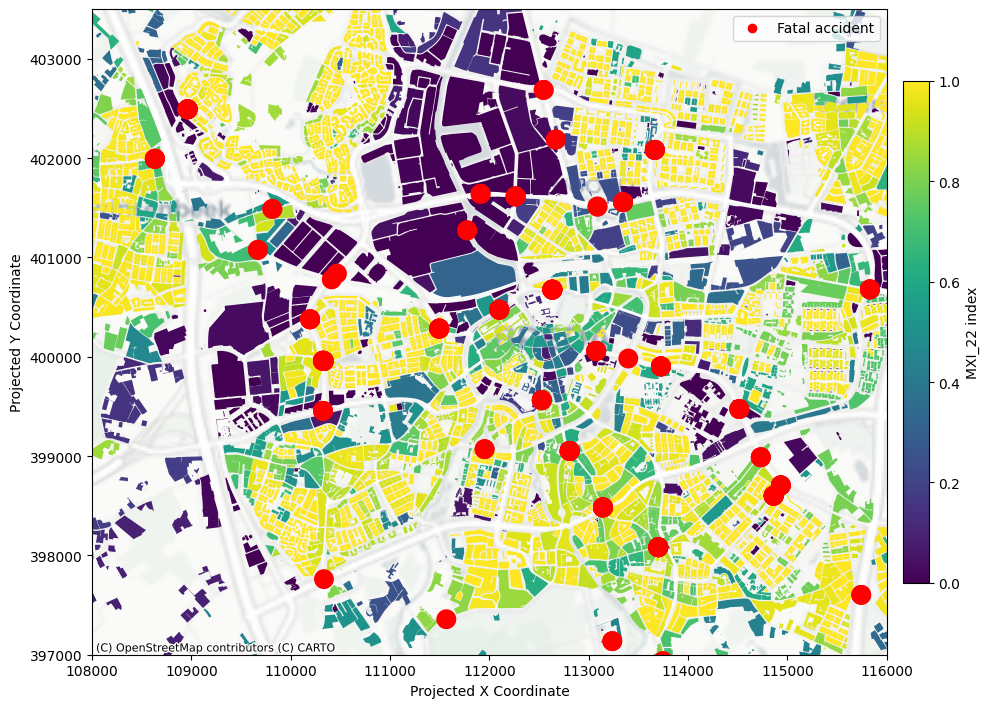

In [90]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Select single region
breda_accidents = intersection_100.loc[(intersection_100.Severity_level == 'DOD') 
                                   & (intersection_100.Municipality_name == 'Breda')]

# Set figure

fig, ax = plt.subplots(1,1, figsize= [10,10])

# plot Rudifun for Breda
breda.plot(column = 'MXI_22', ax= ax)

# plot traffic accidents in Breda
breda_accidents.plot(ax = ax, markersize= 0.01, color = 'r')

# create legend for Fatal accidents
dod_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                           markersize=6, label='Fatal accident')


ctx.add_basemap(crs= 'EPSG:28992', ax = ax, source= 'CartoDB.Positron')

# Add the legend 
ax.legend(handles=[dod_circle], loc='upper right')

# Limit 
ax.set_xlim([108000, 116000])
ax.set_ylim([397000, 403500])
ax.set_xlabel('Projected X Coordinate')
ax.set_ylabel('Projected Y Coordinate')


sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=breda['MXI_22'].min(), vmax=breda['MXI_22'].max()))
sm._A = []  # empty array for colorbar
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)  # shrink size here
cbar.set_label("MXI_22 index")

plt.tight_layout()
plt.savefig("breda_fatal_mixed_index.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [174]:
agg_stats_100 = intersection_100.groupby('Accident_Id').agg({
    'FSI_22': ['mean', 'std', 'min', 'max'],
    'GSI_22': ['mean', 'std', 'min', 'max'],
    'OSR_22': ['mean', 'std', 'min', 'max'],
    'L_22':   ['mean', 'std', 'min', 'max'],
    'MXI_22': ['mean', 'std', 'min', 'max']
})

agg_stats_100.columns = [f"{col[0]}_{col[1]}" for col in agg_stats_100.columns]
agg_stats_100 = agg_stats_100.reset_index()

In [175]:
both_100 = non_highway_accidents_100.merge(agg_stats_100, on = 'Accident_Id', how = 'left')


In [178]:
# Drop overlapping columns in 'both'
cols_to_add = both_100.columns.difference(post_road_cat_100.columns).tolist() + ['Accident_Id']

# Mrge  on the extra columns from 'both'
merged_100 = post_road_cat_100.merge(both_100[cols_to_add], 
                                     on='Accident_Id', how='left').set_index(post_road_cat_100.index)



In [179]:
merged_100 = merged_100.set_geometry(col= 'geometry')

In [180]:
joblib.dump(merged_100, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/df100post_rudifun.pkl')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/df100post_rudifun.pkl']

In [293]:
merged_100 = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/df100post_rudifun.pkl')

#### CBS, Demographic information

In [181]:
cols = [
    'personenautos_per_huishouden', 'motortweewielers_totaal',
    'ziekenhuis_incl_buitenpolikliniek_gem_afst_in_km', 'grote_supermarkt_gemiddelde_afstand_in_km',
    'winkels_ov_dagelijkse_levensm_gem_afst_in_km', 'cafe_gemiddelde_afstand_in_km',
    'restaurant_gemiddelde_afstand_in_km', 'kinderdagverblijf_gemiddelde_afstand_in_km',
    'buitenschoolse_opvang_gem_afstand_in_km', 'basisonderwijs_gemiddelde_afstand_in_km',
    'voortgezet_onderwijs_gem_afstand_in_km', 'vmbo_gemiddelde_afstand_in_km',
    'havo_vwo_gemiddelde_afstand_in_km', 'brandweerkazerne_gemiddelde_afstand_in_km',
    'oprit_hoofdverkeersweg_gemiddelde_afstand_in_km', 'treinstation_gemiddelde_afstand_in_km',
    'percentage_bouwjaarklasse_vanaf_2000', 'percentage_bouwjaarklasse_tot_2000',
    'gemiddelde_woningwaarde', 'bevolkingsdichtheid_inwoners_per_km2', 'geometry'
]

In [182]:
cbs = gpd.read_file('/Users/jorissoolsma/Downloads/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg', columns=cols)

/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(


In [183]:
cbs.replace({-99997: -1, -99995: -1}, inplace=True)

In [184]:
post_cbs_100 = merged_100.sjoin(cbs, how = 'left', predicate= 'within' )

In [185]:
joblib.dump(post_cbs_100, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/post_cbs_100')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/post_cbs_100']

# **2. Preprocessing**

In [68]:
post_cbs_100 = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/post_cbs_100')

#### apply mapping of original feature values

In [69]:
def apply_mappings(df):
    road_surface_map = {
        1: "ZOAB",
        2: "Overig asfalt",
        3: "Beton",
        4: "Klinkers",
        5: "Onverhard",
        6: "Grind tegels",
        7: "Hout tegels"
    }

    weather_map = {
        "D": "Dry",
        "R": "Rain",
        "M": "Fog",
        "S": "Snow/Hail",
        "H": "Strong gusts of wind",
        "O": "Unknown"
    }

    road_segment_map = {
        1: "Rechte weg",
        2: "Bocht",
        3: "Rotonde",
        4: "Kruispunt 3 takken",
        5: "Kruispunt 4 takken",
        6: "Rechte weg - gescheiden rijbanen",
        7: "Invoegstrook op (auto)snelweg",
        8: "Uitvoegstrook op (auto)snelweg"
    }

    collision_type = {
        3: "Animal",
        9: "Single vehicle",
        7: "Side impact",
        6: "Head-on",
        2: "Parked vehicle",
        8: "Rear-end",
        5: "Loose object",
        0: "Unknown",
        4: "Fixed object",
        1: "Pedestrian"
    }

    lighting_condition_dict = {
        1: "Lit",
        2: "Not lit",
        3: "Not present"
    }

    surface_condition_dict = {
        1: "Dry",
        2: "Wet",
        3: "Snow/ice"
    }

    light_map = {
        1: "Daylight",
        2: "Darkness",
        3: "Twilight"
    }


    df['Road_surface'] = df['Road_surface'].map(road_surface_map)
    df['Weather_conditions_1'] = df['Weather_conditions_1'].map(weather_map)
    df['Weather_conditions_2'] = df['Weather_conditions_2'].map(weather_map)
    df['Road_segment_type'] = df['Road_segment_type'].map(road_segment_map)
    df['Nature_of_accident'] = df['Nature_of_accident'].map(collision_type)
    df['Streetlight_status'] = df['Streetlight_status'].map(lighting_condition_dict)
    df['Road_surface_condition'] = df['Road_surface_condition'].map(surface_condition_dict)
    df['Natural_light'] = df['Natural_light'].map(light_map)



    return df

# Apply to both DataFrames
post_cbs_100 = apply_mappings(post_cbs_100)

#### subset on not unknown, inaccurate, or non-logical values

In [70]:
post_cbs_100 = post_cbs_100[post_cbs_100['Nature_of_accident'] != 'Unknown']


In [71]:
post_cbs_100 = post_cbs_100[post_cbs_100['Location_accuracy'] != 'K']


In [72]:
post_cbs_100 = post_cbs_100[post_cbs_100['Nr_of_parties'] != 0]


#### Feature engineering: Crossing 

In [73]:
post_cbs_100['Crossing'] = post_cbs_100['JTE_ID'].notna().astype(int)


#### Fill Max Speed missing

In [74]:
max_speed_df = gpd.read_file('/Users/jorissoolsma/Downloads/Max_snelheden/Snelheden.shp')

In [75]:
max_speed_unique = max_speed_df.sort_values('MAXSHD', ascending=False).drop_duplicates('WVK_ID')

max_spd_table = max_speed_unique.set_index('WVK_ID')['MAXSHD']

In [76]:
mask_missing_100 = post_cbs_100['Max_speed'].isna()

In [77]:
post_cbs_100.loc[mask_missing_100, 'Max_speed'] = post_cbs_100.loc[mask_missing_100, 'WVK_ID'].map(max_spd_table)


/var/folders/c2/9ncptkzj657d0bp07xyq26y00000gn/T/ipykernel_44820/4230544679.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  post_cbs_100.loc[mask_missing_100, 'Max_speed'] = post_cbs_100.loc[mask_missing_100, 'WVK_ID'].map(max_spd_table)


In [78]:
def clean_max_speed_column(series):
    def parse_speed(val):
        if pd.isna(val):
            return -2  # True missing data
        elif str(val).lower() == 'onbekend':
            return -1  # Known, but not a normal road (bike path, etc.)
        try:
            return int(float(val))
        except:
            return -2  # Missing after merging
    
    return series.apply(parse_speed)


post_cbs_100['Max_speed_clean'] = clean_max_speed_column(post_cbs_100['Max_speed'])

In [79]:
post_cbs_100 = post_cbs_100.drop(columns='Max_speed')

In [80]:
post_cbs_100 = post_cbs_100.drop(columns=['index_right'], errors='ignore')

#### fill Urban missing

In [81]:
urbanzone_df = gpd.read_file('/Users/jorissoolsma/Desktop/Programming/Main_Notebooks/bebouwde_kom_2024.json')

In [82]:
urban_merged_100 = post_cbs_100.sjoin(urbanzone_df, how='inner', predicate='within')


In [83]:
# Set fill values to BI and BU on whether they share an index in the merged dataset
fill_values = post_cbs_100.loc[post_cbs_100['Urban_zone'].isna()].index.map(
    lambda idx: 'BI' if idx in urban_merged_100.index else 'BU'
)

# Set missing values to fill values
post_cbs_100.loc[post_cbs_100['Urban_zone'].isna(), 'Urban_zone'] = fill_values

#### Drop columns with large % of missing values

In [84]:
threshold = 0.2 * int(post_cbs_100.shape[0])

In [85]:
post_drop_100 = post_cbs_100.dropna(axis = 1, thresh=threshold)

In [86]:
dropped =  post_drop_100.drop(columns = ['Accident_Id', 'Location_accuracy','JTE_ID','WVK_ID', 'Location_id', 'Municipality_Id', 'Municipality_name','Province_Id', 'geometry', 'DATUM_VKL','buffer_100m'] ).copy()


<Axes: >

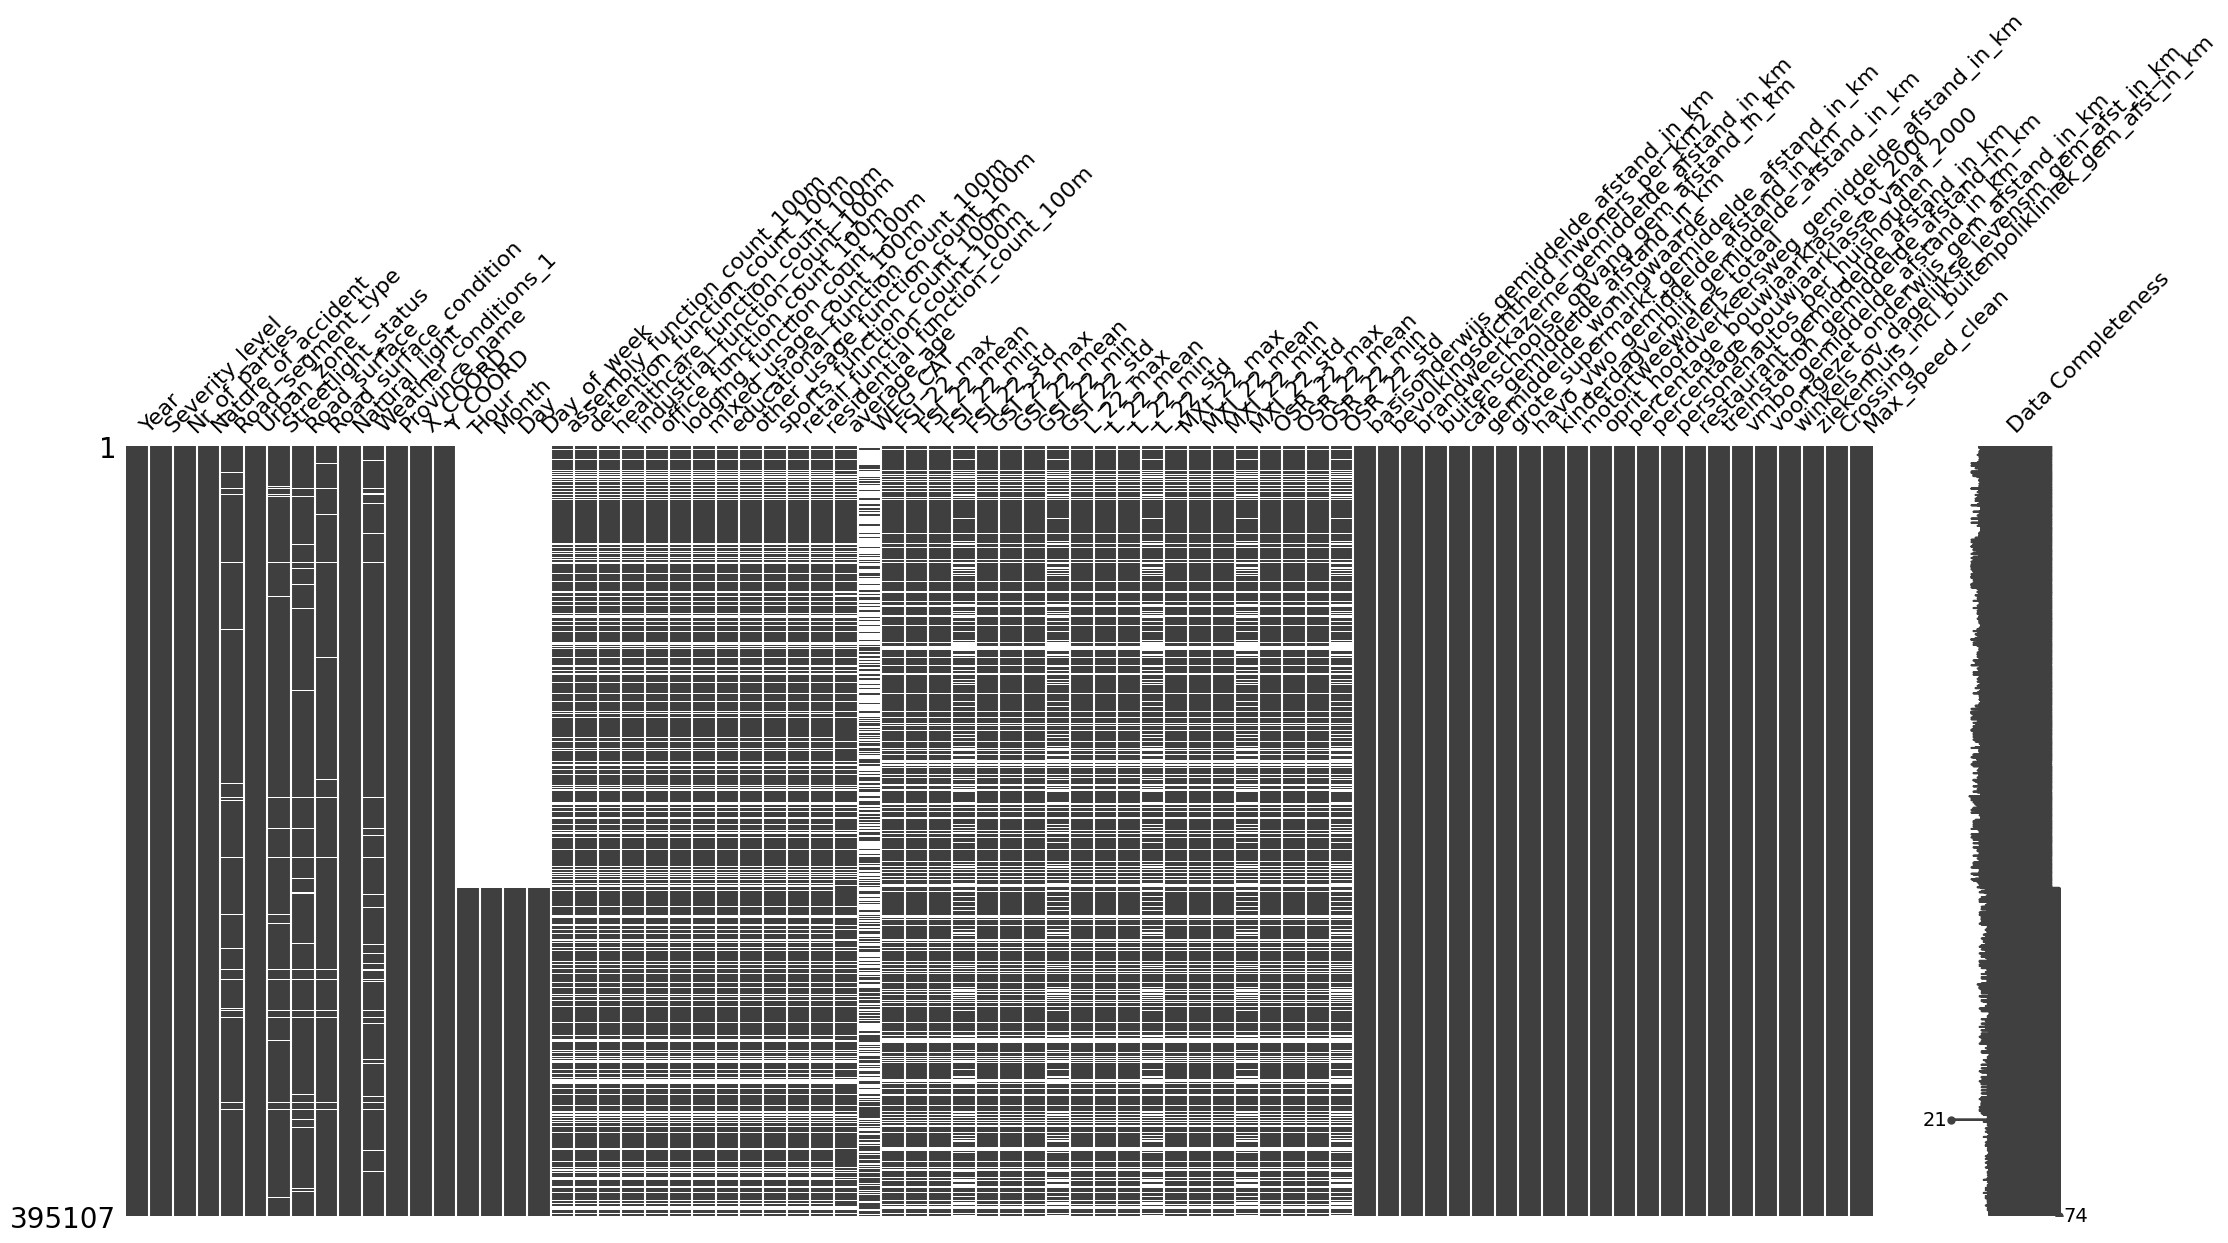

In [88]:
msno.matrix(dropped, labels= True)

#### Split

In [37]:
# buffer 100m
X = post_drop_100.drop(columns= 'Severity_level')
y = post_drop_100.Severity_level

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle= True, random_state=42)

In [38]:
# Save so this can be used in the second main file for further imputation and comparison between the buffers
joblib.dump((X_train, X_test, y_train, y_test), '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/train_test_100.pkl')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/train_test_100.pkl']

In [39]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train, shuffle = True
)

In [306]:
total = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

print(f"X_train: {X_train.shape}, in %: {X_train.shape[0]/total}")
print(f"X_val: {X_val.shape}, in %: {X_val.shape[0]/total}")
print(f"X_test: {X_test.shape}, in %: {X_test.shape[0]/total}")
print(total)

X_train: (237063, 84), in %: 0.5999969628480386
X_val: (79022, 84), in %: 0.2000015185759807
X_test: (79022, 84), in %: 0.2000015185759807
395107


In [307]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Severity_level
UMS    0.743305
LET    0.247846
DOD    0.008850
Name: proportion, dtype: float64
Severity_level
UMS    0.743312
LET    0.247842
DOD    0.008846
Name: proportion, dtype: float64
Severity_level
UMS    0.743312
LET    0.247842
DOD    0.008846
Name: proportion, dtype: float64


#### time feature imputation & transformation

In [ ]:
# Time feature imputation
time_features = ['Hour', 'Month', 'Day', 'Day_of_week']
known_years = [2021, 2022, 2023]


In [ ]:
X_train_full_100m = X_train.copy()
X_train_full_100m['Severity_level'] = y_train

In [52]:
from collections import defaultdict
import numpy as np
import calendar

time_features = ['Hour', 'Month', 'Day', 'Day_of_week']
known_years = [2021, 2022, 2023]

def compute_empirical_distributions(df, target_col='Severity_level'):
    empirical_dists = defaultdict(dict)
    train_known = df[df['Year'].isin(known_years)]
    for cls in train_known[target_col].unique():
        for feat in time_features:
            counts = train_known[train_known[target_col] == cls][feat].value_counts(normalize=True).sort_index()
            empirical_dists[cls][feat] = counts
    return empirical_dists

In [53]:
def sample_from_empirical(dist_series):
    values = dist_series.index.values
    probs = dist_series.values
    return np.random.choice(values, p=probs)

def impute_time_features(df, dists, target_col='Severity_level'):
    def impute_row(row):
        cls = row[target_col]
        if row['Year'] not in known_years:
            for feat in time_features:
                dist = dists.get(cls, {}).get(feat)
                if dist is not None:
                    row[feat] = sample_from_empirical(dist)
        return row

    return df.apply(impute_row, axis=1)

In [54]:
def add_cyclical_features(df):
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    days_in_month = df.apply(lambda row: calendar.monthrange(int(row['Year']), int(row['Month']))[1], axis=1)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / days_in_month)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / days_in_month)

    df['Day_of_week_sin'] = np.sin(2 * np.pi * df['Day_of_week'] / 7)
    df['Day_of_week_cos'] = np.cos(2 * np.pi * df['Day_of_week'] / 7)
    return df


In [55]:
def preprocess_train_test(X_train, y_train, X_test, y_test):
    # Create combined train set for empirical distributions
    X_train_full = X_train.copy()
    X_train_full['Severity_level'] = y_train

    empirical_dists = compute_empirical_distributions(X_train_full)

    # Impute training and test sets
    X_train_imp = X_train.copy()
    X_train_imp['Severity_level'] = y_train
    X_test_imp = X_test.copy()
    X_test_imp['Severity_level'] = y_test

    X_train_imp = impute_time_features(X_train_imp, empirical_dists)
    X_test_imp = impute_time_features(X_test_imp, empirical_dists)

    # Drop rows with missing time features
    cols_to_int = ['Hour', 'Month', 'Day', 'Day_of_week']
    X_train_imp.dropna(subset=cols_to_int, inplace=True)
    X_test_imp.dropna(subset=cols_to_int, inplace=True)

    # Convert to int
    X_train_imp[cols_to_int] = X_train_imp[cols_to_int].astype(int)
    X_test_imp[cols_to_int] = X_test_imp[cols_to_int].astype(int)

    # Add cyclical features
    X_train_imp = add_cyclical_features(X_train_imp)
    X_test_imp = add_cyclical_features(X_test_imp)

    # Drop original features and target column
    X_train_imp.drop(columns=cols_to_int + ['Severity_level'], inplace=True)
    X_test_imp.drop(columns=cols_to_int + ['Severity_level'], inplace=True)

    # Align labels
    y_train_aligned = y_train.loc[X_train_imp.index]
    y_test_aligned = y_test.loc[X_test_imp.index]

    return X_train_imp, y_train_aligned, X_test_imp, y_test_aligned


In [58]:
# 100m buffer
X_train_100m, y_train_100m, X_val_100m, y_val_100m = preprocess_train_test(
    X_train, y_train, X_val, y_val
)

In [57]:
def finalize_missing_values(X_train, X_test):
    X_train_f = X_train.copy()
    X_test_f = X_test.copy()

    # Fill 100m/200m/400m features with 0
    for df in (X_train_f, X_test_f):
        suffix_cols = [col for col in df.columns if col.endswith(('100m', '200m', '400m'))]
        df[suffix_cols] = df[suffix_cols].fillna(0)

    # Fill numeric features with 0
    numeric_cols = X_train_f.select_dtypes(include='number').columns
    for col in numeric_cols:
        mean_val = X_train_f[col].mean()
        # vul missings in train en test met die training‐mean
        X_train_f[col].fillna(mean_val)
        X_test_f[col].fillna(mean_val)

    # Fill categorical features with mode
    cat_cols = X_train_f.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        mode_series = X_train_f[col].mode().dropna()
        if not mode_series.empty:
            mode_val = mode_series[0]
            X_train_f[col] = X_train_f[col].fillna(mode_val)
            if col in X_test_f.columns:
                X_test_f[col] = X_test_f[col].fillna(mode_val)

    return X_train_f, X_test_f


In [59]:
X_train_100m_final, X_val_100m_final = finalize_missing_values(X_train_100m, X_val_100m)

In [61]:
cols_to_drop100m = ['Accident_Id', 'DATUM_VKL','JTE_ID', 'Location_accuracy', 'Location_id','Municipality_Id',
 'Municipality_name','Province_Id','WVK_ID','buffer_100m', 'geometry']

In [62]:
X_train_100m_final = X_train_100m_final.drop(columns=cols_to_drop100m)
X_val_100m_final = X_val_100m_final.drop(columns=cols_to_drop100m)

In [85]:
X_train_100m_final.fillna(0, inplace=True)
X_val_100m_final.fillna(0,   inplace=True)

In [86]:
joblib.dump((X_train_100m_final, y_train_100m, X_val_100m_final, y_val_100m),'/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/train_val_final.pkl')


['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/train_val_final.pkl']

In [6]:
X_train_100m_final, y_train_100m, X_val_100m_final, y_val_100m = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/train_val_final.pkl')

#### One-hot Encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

def encode_and_save(X_train_final, X_test_final, y_train, y_test, save_path):
    # Identify categorical and numeric columns
    categorical_cols = X_train_final.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = [col for col in X_train_final.columns if col not in categorical_cols]

    # Set up pipelines
    cat_pipeline = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    num_pipeline = MinMaxScaler()  # scales numeric features to 0-1

    # Set up ColumnTransformer with both pipelines
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', cat_pipeline, categorical_cols),
            ('num', num_pipeline, numeric_cols)
        ]
    )

    # Fit on training data and transform both sets
    X_train_encoded = preprocessor.fit_transform(X_train_final)
    X_test_encoded = preprocessor.transform(X_test_final)

    # Get feature names
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = list(cat_features) + numeric_cols  # numeric names remain the same

    # Save to disk
    joblib.dump((X_train_encoded, X_test_encoded, y_train, y_test, feature_names), save_path)

    return X_train_encoded, X_test_encoded, feature_names


In [8]:
X_train_encoded, X_val_encoded, feature_names_100m = encode_and_save(
    X_train_100m_final,
    X_val_100m_final,
    y_train_100m,
    y_val_100m,
    '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/train_val_encoded.pkl'
)

In [122]:
frames = [X_train_encoded, y_train_100m, X_val_encoded, y_val_100m]

In [136]:
joblib.dump((X_train_encoded, y_train_100m, X_val_encoded, y_val_100m), '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/train_val_enc')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/train_val_enc']

In [4]:
X_train_encoded, y_train_100m, X_val_encoded, y_val_100m = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/train_val_enc')

## Resampling technique overview

#### Set undersampling

In [9]:
# Cell 1: imports en globale setup
import os
from collections import Counter
import pandas as pd
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# aannames: X_train_encoded, y_train_100m bestaan al
TARGET_N = 15000
feature_cols = feature_names_100m

# undersampler: elke klasse terugbrengen naar TARGET_N
rus = RandomUnderSampler(
    random_state=42,
    sampling_strategy={cls: TARGET_N for cls in pd.unique(y_train_100m)}
)

out_dir = '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets'
os.makedirs(out_dir, exist_ok=True)


#### SMOTE + Undersampling

In [124]:
# Cell 2: SMOTE → oversample DOD naar TARGET_N, dan undersample alles naar TARGET_N

print("Original training class distribution:", Counter(y_train_100m))

smote = SMOTE(
    random_state=42,
    k_neighbors=5,
    sampling_strategy={'DOD': TARGET_N}
)
X_smote, y_smote = smote.fit_resample(X_train_encoded, y_train_100m)
print("After SMOTE:", Counter(y_smote))

smote_df = pd.DataFrame(X_smote, columns=feature_cols)
smote_df['severity_level'] = y_smote
smote_df.to_parquet(os.path.join(out_dir, f'smote_{TARGET_N}.parquet'))

X_final, y_final = rus.fit_resample(X_smote, y_smote)
print("After RandomUndersampler:", Counter(y_final))

undersampled_df = pd.DataFrame(X_final, columns=feature_cols)
undersampled_df['severity_level'] = y_final
undersampled_df.to_parquet(os.path.join(out_dir, f'smote_{TARGET_N}_undersampled.parquet'))


Original training class distribution: Counter({'UMS': 176210, 'LET': 58755, 'DOD': 2098})
After SMOTE: Counter({'UMS': 176210, 'LET': 58755, 'DOD': 15000})
After RandomUndersampler: Counter({'DOD': 15000, 'LET': 15000, 'UMS': 15000})


#### BL_smote + undersampling

In [125]:
# Cell 3: BorderlineSMOTE → oversample DOD naar TARGET_N, dan undersample alles naar TARGET_N

print("Original training class distribution:", Counter(y_train_100m))

bl = BorderlineSMOTE(
    random_state=42,
    sampling_strategy={'DOD': TARGET_N}
)
X_bl, y_bl = bl.fit_resample(X_train_encoded, y_train_100m)
print("After BorderlineSMOTE:", Counter(y_bl))

bl_df = pd.DataFrame(X_bl, columns=feature_cols)
bl_df['severity_level'] = y_bl
bl_df.to_parquet(os.path.join(out_dir, f'bl_smote_{TARGET_N}.parquet'))

X_final, y_final = rus.fit_resample(X_bl, y_bl)
print("After RandomUndersampler:", Counter(y_final))

undersampled_df = pd.DataFrame(X_final, columns=feature_cols)
undersampled_df['severity_level'] = y_final
undersampled_df.to_parquet(os.path.join(out_dir, f'bl_smote_{TARGET_N}_undersampled.parquet'))


Original training class distribution: Counter({'UMS': 176210, 'LET': 58755, 'DOD': 2098})
After BorderlineSMOTE: Counter({'UMS': 176210, 'LET': 58755, 'DOD': 15000})
After RandomUndersampler: Counter({'DOD': 15000, 'LET': 15000, 'UMS': 15000})


#### SMOTEENN

In [126]:
# --- SMOTEENN Oversampling ---
# --- SMOTEENN Oversampling for UMS & LET ---
print("Original training class distribution:", Counter(y_train_100m))

smoteenn = SMOTEENN(
    random_state=42,
    sampling_strategy={'DOD': TARGET_N}
)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train_encoded, y_train_100m)

print("After SMOTEENN:", Counter(y_smoteenn))

smoteenn_df = pd.DataFrame(X_smoteenn, columns=feature_cols)
smoteenn_df['severity_level'] = y_smoteenn
smoteenn_df.to_parquet(
    '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/smotenn.parquet'
)

# --- Random Undersampling to bring UMS & LET back to 10k each ---
rus = RandomUnderSampler(
    random_state=42,
    sampling_strategy={'UMS': TARGET_N}
)
X_final, y_final = rus.fit_resample(X_smoteenn, y_smoteenn)

print("After RandomUndersampler:", Counter(y_final))

undersampled_df = pd.DataFrame(X_final, columns=feature_cols)
undersampled_df['severity_level'] = y_final
undersampled_df.to_parquet(
    '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/smotenn_undersampled.parquet'
)


Original training class distribution: Counter({'UMS': 176210, 'LET': 58755, 'DOD': 2098})
After SMOTEENN (UMS & LET → 10k): Counter({'UMS': 92182, 'DOD': 14701, 'LET': 7208})
After RandomUndersampler (UMS & LET → 10k): Counter({'UMS': 15000, 'DOD': 14701, 'LET': 7208})


#### ADASYN + Undersampling

In [18]:
# Cell 5: ADASYN oversample DOD naar TARGET_N, dan undersample alles naar TARGET_N

print("Original training class distribution:", Counter(y_train_100m))

ada = ADASYN(
    random_state=42,
    sampling_strategy={'DOD': TARGET_N}
)
X_ada, y_ada = ada.fit_resample(X_train_encoded, y_train_100m)
print("After ADASYN:", Counter(y_ada))

# Create Dataframa with ADASYN
ada_df = pd.DataFrame(X_ada, columns=feature_cols)
ada_df['severity_level'] = y_ada
ada_df.to_parquet(os.path.join(out_dir, f'adasyn_{TARGET_N}.parquet'))


# Set RUS to maximal sampling size of Fatal class by ADASYN
rus = RandomUnderSampler(
    random_state=42,
    sampling_strategy={'DOD': (y_ada == 'DOD').sum(), 'LET': 15000, 'UMS':150000}
)

X_final, y_final = rus.fit_resample(X_ada, y_ada)
print("After RandomUndersampler:", Counter(y_final))

undersampled_df = pd.DataFrame(X_final, columns=feature_cols)
undersampled_df['severity_level'] = y_final
undersampled_df.to_parquet(os.path.join(out_dir, f'adasyn_{TARGET_N}_undersampled.parquet'))


Original training class distribution: Counter({'UMS': 176210, 'LET': 58755, 'DOD': 2098})
After ADASYN: Counter({'UMS': 176210, 'LET': 58755, 'DOD': 14383})
After RandomUndersampler: Counter({'UMS': 150000, 'LET': 15000, 'DOD': 14383})


### Read Resampled datasets

In [91]:
borderline_df = pd.read_parquet('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/bl_smote_15000.parquet')
borderline_undersampled_df = pd.read_parquet('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/bl_smote_15000_undersampled.parquet')

adasyn_df =  pd.read_parquet('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/adasyn_15000.parquet')
adasyn_undersampled_df = pd.read_parquet('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/adasyn_15000_undersampled.parquet')

smote_df = pd.read_parquet('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/smote_15000.parquet')
smote_undersampled_df = pd.read_parquet('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/smote_15000_undersampled.parquet')

smotenn_df = pd.read_parquet('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/smotenn.parquet')
smotenn_undersampled_df = pd.read_parquet('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Resampled_datasets/smotenn_undersampled.parquet')



In [92]:
df_dict = {
    'BorderlineSMOTE': borderline_df,
    'BorderlineSMOTE_Undersampled': borderline_undersampled_df,
    
    'ADASYN': adasyn_df,
    'ADASYN_Undersampled': adasyn_undersampled_df,
    
    'SMOTE': smote_df,
    'SMOTE_Undersampled': smote_undersampled_df,
    
    'SMOTEENN': smotenn_df,
    'SMOTEENN_Undersampled': smotenn_undersampled_df
}

# Train

### Selection RQ1 

#### Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Zorg dat df_dict, X_val_encoded en y_val_100m al in je sessie aanwezig zijn

summary_logreg = {}

# Maak een LabelEncoder voor de drie klassen
le = LabelEncoder()
le.fit(['DOD', 'LET', 'UMS'])

for name, data in df_dict.items():
    print(f"Training Logistic Regression on {name}...")
    
    # train-split
    X_train_res = data.drop(columns='severity_level')
    y_train_res = data['severity_level']
    
    # encode y
    y_train_enc = le.transform(y_train_res)
    y_val_enc   = le.transform(y_val_100m)
    
    # init model
    clf = LogisticRegression(
        solver='saga',
        penalty='l2',
        C=1.0,
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
    
    # train & predict
    clf.fit(X_train_res, y_train_enc)
    y_val_pred_enc = clf.predict(X_val_encoded)
    y_val_pred     = le.inverse_transform(y_val_pred_enc)
    
    # classification report
    report = classification_report(y_val_100m, y_val_pred, output_dict=True)
    
    # metrics verzamelen
    summary_logreg[name] = {
        'DOD Precision': report['DOD']['precision'],
        'DOD Recall':    report['DOD']['recall'],
        'LET Precision': report['LET']['precision'],
        'LET Recall':    report['LET']['recall'],
        'UMS Precision': report['UMS']['precision'],
        'UMS Recall':    report['UMS']['recall'],
        'Macro F1':      report['macro avg']['f1-score'],
        'Accuracy':      report['accuracy']
    }

# samenvattende DataFrame
summary_logreg_df = (
    pd.DataFrame.from_dict(summary_logreg, orient='index')
      .sort_values('Macro F1', ascending=False)
      .round(2)
)

print("\n=== Summary Logistic Regression ===")
print(summary_logreg_df)


Training Logistic Regression on BorderlineSMOTE...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Training Logistic Regression on BorderlineSMOTE_Undersampled...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Training Logistic Regression on ADASYN...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Training Logistic Regression on ADASYN_Undersampled...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Training Logistic Regression on SMOTE...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Training Logistic Regression on SMOTE_Undersampled...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Training Logistic Regression on SMOTEENN...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Training Logistic Regression on SMOTEENN_Undersampled...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



=== Summary Logistic Regression ===
                              DOD Precision  DOD Recall  LET Precision  \
BorderlineSMOTE                        0.08        0.14           0.69   
ADASYN                                 0.12        0.07           0.68   
SMOTE                                  0.11        0.08           0.69   
BorderlineSMOTE_Undersampled           0.03        0.50           0.43   
SMOTEENN                               0.04        0.35           0.77   
SMOTE_Undersampled                     0.03        0.60           0.43   
SMOTEENN_Undersampled                  0.02        0.64           0.65   
ADASYN_Undersampled                    0.07        0.16           0.86   

                              LET Recall  UMS Precision  UMS Recall  Macro F1  \
BorderlineSMOTE                     0.28           0.80        0.95      0.46   
ADASYN                              0.29           0.80        0.96      0.46   
SMOTE                               0.29           0.

In [53]:
joblib.dump(summary_logreg_df, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/logreg')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/logreg']

In [54]:
summary_logreg_df

,DOD Precision,DOD Recall,LET Precision,LET Recall,UMS Precision,UMS Recall,Macro F1,Accuracy
BorderlineSMOTE,0.08,0.14,0.69,0.28,0.80,0.95,0.46,0.78
ADASYN,0.12,0.07,0.68,0.29,0.80,0.96,0.46,0.78
SMOTE,0.11,0.08,0.69,0.29,0.80,0.96,0.45,0.78
BorderlineSMOTE_Undersampled,0.03,0.50,0.43,0.50,0.86,0.66,0.42,0.62
SMOTEENN,0.04,0.35,0.77,0.19,0.80,0.93,0.42,0.75
SMOTE_Undersampled,0.03,0.60,0.43,0.47,0.86,0.61,0.41,0.58
SMOTEENN_Undersampled,0.02,0.64,0.65,0.25,0.83,0.73,0.39,0.61
ADASYN_Undersampled,0.07,0.16,0.86,0.10,0.77,0.98,0.38,0.76


#### Random Forests

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

summary_rf = {}
le = LabelEncoder()
le.fit(['DOD', 'LET', 'UMS'])

for name, data in df_dict.items():
    print(f"Training Random Forest on {name}...")

    X_train_res = data.drop(columns='severity_level')
    y_train_res = data['severity_level']

    y_train_enc = le.transform(y_train_res)
    y_val_enc   = le.transform(y_val_100m)

    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train_res, y_train_enc)
    y_val_pred_enc = clf.predict(X_val_encoded)
    y_val_pred     = le.inverse_transform(y_val_pred_enc)

    report = classification_report(y_val_100m, y_val_pred, output_dict=True, zero_division=0)

    summary_rf[name] = {
        'DOD Precision': report['DOD']['precision'],
        'DOD Recall':    report['DOD']['recall'],
        'LET Precision': report['LET']['precision'],
        'LET Recall':    report['LET']['recall'],
        'UMS Precision': report['UMS']['precision'],
        'UMS Recall':    report['UMS']['recall'],
        'Macro F1':      report['macro avg']['f1-score'],
        'Accuracy':      report['accuracy']
    }

summary_rf_df = pd.DataFrame.from_dict(summary_rf, orient='index').sort_values('Macro F1', ascending=False).round(2)
print("\n=== Summary Random Forest ===")
print(summary_rf_df)


Training Random Forest on BorderlineSMOTE...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training Random Forest on BorderlineSMOTE_Undersampled...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training Random Forest on ADASYN...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training Random Forest on ADASYN_Undersampled...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training Random Forest on SMOTE...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training Random Forest on SMOTE_Undersampled...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training Random Forest on SMOTEENN...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training Random Forest on SMOTEENN_Undersampled...


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



=== Summary Random Forest ===
                              DOD Precision  DOD Recall  LET Precision  \
BorderlineSMOTE_Undersampled           0.08        0.14           0.42   
SMOTE_Undersampled                     0.06        0.16           0.41   
SMOTEENN_Undersampled                  0.05        0.30           0.67   
SMOTE                                  0.16        0.01           0.70   
ADASYN                                 0.22        0.01           0.70   
BorderlineSMOTE                        0.31        0.01           0.69   
SMOTEENN                               0.07        0.08           0.76   
ADASYN_Undersampled                    0.19        0.01           0.88   

                              LET Recall  UMS Precision  UMS Recall  Macro F1  \
BorderlineSMOTE_Undersampled        0.62           0.85        0.71      0.46   
SMOTE_Undersampled                  0.60           0.85        0.70      0.45   
SMOTEENN_Undersampled               0.28           0.81    

In [56]:
joblib.dump(summary_rf_df, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/rf')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/rf']

In [57]:
summary_rf_df

,DOD Precision,DOD Recall,LET Precision,LET Recall,UMS Precision,UMS Recall,Macro F1,Accuracy
BorderlineSMOTE_Undersampled,0.08,0.14,0.42,0.62,0.85,0.71,0.46,0.68
SMOTE_Undersampled,0.06,0.16,0.41,0.60,0.85,0.70,0.45,0.67
SMOTEENN_Undersampled,0.05,0.30,0.67,0.28,0.81,0.91,0.45,0.75
SMOTE,0.16,0.01,0.70,0.31,0.80,0.96,0.44,0.79
ADASYN,0.22,0.01,0.70,0.31,0.80,0.96,0.44,0.79
BorderlineSMOTE,0.31,0.01,0.69,0.31,0.80,0.96,0.44,0.79
SMOTEENN,0.07,0.08,0.76,0.23,0.79,0.97,0.43,0.78
ADASYN_Undersampled,0.19,0.01,0.88,0.10,0.76,1.00,0.35,0.76


#### XGBoost

In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

summary_xgb = {}
le = LabelEncoder()
le.fit(['DOD', 'LET', 'UMS'])

for name, data in df_dict.items():
    print(f"Training XGBoost on {name}...")

    X_train_res = data.drop(columns='severity_level')
    y_train_res = data['severity_level']

    y_train_enc = le.transform(y_train_res)
    y_val_enc   = le.transform(y_val_100m)

    clf = XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    clf.fit(X_train_res, y_train_enc)
    y_val_pred_enc = clf.predict(X_val_encoded)
    y_val_pred     = le.inverse_transform(y_val_pred_enc)

    report = classification_report(y_val_100m, y_val_pred, output_dict=True, zero_division=0)

    summary_xgb[name] = {
        'DOD Precision': report['DOD']['precision'],
        'DOD Recall':    report['DOD']['recall'],
        'LET Precision': report['LET']['precision'],
        'LET Recall':    report['LET']['recall'],
        'UMS Precision': report['UMS']['precision'],
        'UMS Recall':    report['UMS']['recall'],
        'Macro F1':      report['macro avg']['f1-score'],
        'Accuracy':      report['accuracy']
    }

summary_xgb_df = pd.DataFrame.from_dict(summary_xgb, orient='index').sort_values('Macro F1', ascending=False).round(2)
print("\n=== Summary XGBoost ===")
print(summary_xgb_df)


Training XGBoost on BorderlineSMOTE...
Training XGBoost on BorderlineSMOTE_Undersampled...
Training XGBoost on ADASYN...
Training XGBoost on ADASYN_Undersampled...
Training XGBoost on SMOTE...
Training XGBoost on SMOTE_Undersampled...
Training XGBoost on SMOTEENN...
Training XGBoost on SMOTEENN_Undersampled...

=== Summary XGBoost ===
                              DOD Precision  DOD Recall  LET Precision  \
SMOTEENN_Undersampled                  0.07        0.28           0.65   
SMOTE_Undersampled                     0.10        0.09           0.44   
BorderlineSMOTE_Undersampled           0.07        0.13           0.44   
SMOTEENN                               0.10        0.12           0.77   
BorderlineSMOTE                        0.21        0.00           0.75   
SMOTE                                  1.00        0.00           0.75   
ADASYN                                 0.00        0.00           0.75   
ADASYN_Undersampled                    0.32        0.01           0.85 

In [59]:
joblib.dump(summary_xgb_df, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/xgb')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/xgb']

In [60]:
summary_xgb_df

,DOD Precision,DOD Recall,LET Precision,LET Recall,UMS Precision,UMS Recall,Macro F1,Accuracy
SMOTEENN_Undersampled,0.07,0.28,0.65,0.34,0.82,0.92,0.47,0.77
SMOTE_Undersampled,0.10,0.09,0.44,0.65,0.86,0.73,0.47,0.70
BorderlineSMOTE_Undersampled,0.07,0.13,0.44,0.64,0.86,0.72,0.47,0.69
SMOTEENN,0.10,0.12,0.77,0.25,0.79,0.97,0.45,0.79
BorderlineSMOTE,0.21,0.00,0.75,0.31,0.80,0.97,0.44,0.80
SMOTE,1.00,0.00,0.75,0.31,0.80,0.97,0.44,0.80
ADASYN,0.00,0.00,0.75,0.31,0.80,0.97,0.44,0.80
ADASYN_Undersampled,0.32,0.01,0.85,0.18,0.78,0.99,0.40,0.78


#### LightGBM

In [61]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

summary_lgbm = {}
le = LabelEncoder()
le.fit(['DOD', 'LET', 'UMS'])

for name, data in df_dict.items():
    print(f"Training LightGBM on {name}...")

    X_train_res = data.drop(columns='severity_level')
    y_train_res = data['severity_level']

    y_train_enc = le.transform(y_train_res)
    y_val_enc   = le.transform(y_val_100m)

    clf = LGBMClassifier(
        objective='multiclass',
        num_class=3,
        n_estimators=150,
        learning_rate=0.1,
        max_depth=-1,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train_res, y_train_enc)
    y_val_pred_enc = clf.predict(X_val_encoded)
    y_val_pred     = le.inverse_transform(y_val_pred_enc)

    report = classification_report(y_val_100m, y_val_pred, output_dict=True, zero_division=0)

    summary_lgbm[name] = {
        'DOD Precision': report['DOD']['precision'],
        'DOD Recall':    report['DOD']['recall'],
        'LET Precision': report['LET']['precision'],
        'LET Recall':    report['LET']['recall'],
        'UMS Precision': report['UMS']['precision'],
        'UMS Recall':    report['UMS']['recall'],
        'Macro F1':      report['macro avg']['f1-score'],
        'Accuracy':      report['accuracy']
    }

summary_lgbm_df = pd.DataFrame.from_dict(summary_lgbm, orient='index').sort_values('Macro F1', ascending=False).round(2)
print("\n=== Summary LightGBM ===")
print(summary_lgbm_df)


Training LightGBM on BorderlineSMOTE...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26336
[LightGBM] [Info] Number of data points in the train set: 249965, number of used features: 128
[LightGBM] [Info] Start training from score -2.813271
[LightGBM] [Info] Start training from score -1.447945
[LightGBM] [Info] Start training from score -0.349644


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training LightGBM on BorderlineSMOTE_Undersampled...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28192
[LightGBM] [Info] Number of data points in the train set: 45000, number of used features: 127
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training LightGBM on ADASYN...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26927
[LightGBM] [Info] Number of data points in the train set: 249348, number of used features: 128
[LightGBM] [Info] Start training from score -2.852803
[LightGBM] [Info] Start training from score -1.445473
[LightGBM] [Info] Start training from score -0.347173


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training LightGBM on ADASYN_Undersampled...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28031
[LightGBM] [Info] Number of data points in the train set: 179383, number of used features: 128
[LightGBM] [Info] Start training from score -2.523476
[LightGBM] [Info] Start training from score -2.481473
[LightGBM] [Info] Start training from score -0.178888


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training LightGBM on SMOTE...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26958
[LightGBM] [Info] Number of data points in the train set: 249965, number of used features: 128
[LightGBM] [Info] Start training from score -2.813271
[LightGBM] [Info] Start training from score -1.447945
[LightGBM] [Info] Start training from score -0.349644


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training LightGBM on SMOTE_Undersampled...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28689
[LightGBM] [Info] Number of data points in the train set: 45000, number of used features: 127
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training LightGBM on SMOTEENN...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28436
[LightGBM] [Info] Number of data points in the train set: 114091, number of used features: 127
[LightGBM] [Info] Start training from score -2.049081
[LightGBM] [Info] Start training from score -2.761805
[LightGBM] [Info] Start training from score -0.213231


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training LightGBM on SMOTEENN_Undersampled...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28642
[LightGBM] [Info] Number of data points in the train set: 36909, number of used features: 127
[LightGBM] [Info] Start training from score -0.920540
[LightGBM] [Info] Start training from score -1.633264
[LightGBM] [Info] Start training from score -0.900405


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Summary LightGBM ===
                              DOD Precision  DOD Recall  LET Precision  \
SMOTEENN_Undersampled                  0.06        0.27           0.64   
BorderlineSMOTE_Undersampled           0.09        0.13           0.44   
SMOTE_Undersampled                     0.10        0.08           0.44   
SMOTEENN                               0.10        0.12           0.76   
SMOTE                                  0.50        0.00           0.74   
ADASYN                                 0.25        0.00           0.74   
BorderlineSMOTE                        0.20        0.00           0.74   
ADASYN_Undersampled                    0.22        0.02           0.86   

                              LET Recall  UMS Precision  UMS Recall  Macro F1  \
SMOTEENN_Undersampled               0.35           0.82        0.91      0.47   
BorderlineSMOTE_Undersampled        0.65           0.86        0.72      0.47   
SMOTE_Undersampled                  0.65           0.86        0

In [62]:
joblib.dump(summary_lgbm_df, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/lgbm')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/lgbm']

In [63]:
summary_lgbm_df

,DOD Precision,DOD Recall,LET Precision,LET Recall,UMS Precision,UMS Recall,Macro F1,Accuracy
SMOTEENN_Undersampled,0.06,0.27,0.64,0.35,0.82,0.91,0.47,0.77
BorderlineSMOTE_Undersampled,0.09,0.13,0.44,0.65,0.86,0.72,0.47,0.70
SMOTE_Undersampled,0.10,0.08,0.44,0.65,0.86,0.72,0.47,0.70
SMOTEENN,0.10,0.12,0.76,0.26,0.80,0.97,0.46,0.79
SMOTE,0.50,0.00,0.74,0.32,0.80,0.97,0.44,0.80
ADASYN,0.25,0.00,0.74,0.32,0.80,0.97,0.44,0.80
BorderlineSMOTE,0.20,0.00,0.74,0.32,0.80,0.97,0.44,0.80
ADASYN_Undersampled,0.22,0.02,0.86,0.18,0.78,0.99,0.40,0.78


#### Catboost

In [64]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

summary_catboost = {}
le = LabelEncoder()
le.fit(['DOD', 'LET', 'UMS'])

for name, data in df_dict.items():
    print(f"Training CatBoost on {name}...")

    X_train_res = data.drop(columns='severity_level')
    y_train_res = data['severity_level']

    y_train_enc = le.transform(y_train_res)
    y_val_enc   = le.transform(y_val_100m)

    clf = CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        verbose=0,
        random_seed=42
    )

    clf.fit(X_train_res, y_train_enc)
    y_val_pred_enc = clf.predict(X_val_encoded).ravel().astype(int)
    y_val_pred     = le.inverse_transform(y_val_pred_enc)

    report = classification_report(y_val_100m, y_val_pred, output_dict=True, zero_division=0)

    summary_catboost[name] = {
        'DOD Precision': report['DOD']['precision'],
        'DOD Recall':    report['DOD']['recall'],
        'LET Precision': report['LET']['precision'],
        'LET Recall':    report['LET']['recall'],
        'UMS Precision': report['UMS']['precision'],
        'UMS Recall':    report['UMS']['recall'],
        'Macro F1':      report['macro avg']['f1-score'],
        'Accuracy':      report['accuracy']
    }

summary_catboost_df = pd.DataFrame.from_dict(summary_catboost, orient='index').sort_values('Macro F1', ascending=False).round(2)
print("\n=== Summary CatBoost ===")
print(summary_catboost_df)


Training CatBoost on BorderlineSMOTE...
Training CatBoost on BorderlineSMOTE_Undersampled...
Training CatBoost on ADASYN...
Training CatBoost on ADASYN_Undersampled...
Training CatBoost on SMOTE...
Training CatBoost on SMOTE_Undersampled...
Training CatBoost on SMOTEENN...
Training CatBoost on SMOTEENN_Undersampled...

=== Summary CatBoost ===
                              DOD Precision  DOD Recall  LET Precision  \
SMOTE_Undersampled                     0.09        0.13           0.45   
BorderlineSMOTE_Undersampled           0.07        0.20           0.45   
SMOTEENN_Undersampled                  0.06        0.28           0.64   
SMOTEENN                               0.11        0.11           0.77   
BorderlineSMOTE                        0.27        0.01           0.74   
SMOTE                                  0.33        0.00           0.75   
ADASYN                                 0.00        0.00           0.74   
ADASYN_Undersampled                    0.20        0.02       

In [65]:
joblib.dump(summary_catboost_df, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/catboost')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/catboost']

In [66]:
summary_catboost_df

,DOD Precision,DOD Recall,LET Precision,LET Recall,UMS Precision,UMS Recall,Macro F1,Accuracy
SMOTE_Undersampled,0.09,0.13,0.45,0.63,0.86,0.74,0.47,0.70
BorderlineSMOTE_Undersampled,0.07,0.20,0.45,0.62,0.86,0.73,0.47,0.70
SMOTEENN_Undersampled,0.06,0.28,0.64,0.33,0.81,0.91,0.47,0.76
SMOTEENN,0.11,0.11,0.77,0.25,0.79,0.97,0.45,0.79
BorderlineSMOTE,0.27,0.01,0.74,0.31,0.80,0.97,0.45,0.80
SMOTE,0.33,0.00,0.75,0.30,0.80,0.97,0.44,0.80
ADASYN,0.00,0.00,0.74,0.30,0.80,0.97,0.44,0.80
ADASYN_Undersampled,0.20,0.02,0.87,0.17,0.78,0.99,0.40,0.78


### Evaluate Model / Resampling technique

In [93]:
# load
logreg = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/logreg')
rf = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/rf')
xgboost = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/xgb')
lightgbm = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/lgbm')
catboost = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Summaries/catboost')

In [94]:
logreg['name'] = 'LG'
rf['name'] = 'RF'
xgboost['name'] = 'XGB'
lightgbm['name'] = 'LGBM'
catboost['name'] = 'CATBOOST'


In [95]:
def create_method(df):
    df = df.reset_index(names= 'Method')
    return df


In [96]:
logreg = create_method(logreg).sort_values(by = 'Macro F1', ascending = False)
rf = create_method(rf).sort_values(by = 'Macro F1', ascending = False)
xgboost = create_method(xgboost).sort_values(by = 'Macro F1', ascending = False)
lightgbm = create_method(lightgbm).sort_values(by = 'Macro F1', ascending = False)
catboost = create_method(catboost).sort_values(by = 'Macro F1', ascending = False)

In [97]:
grouped = pd.concat([logreg, rf, xgboost, lightgbm, catboost], axis = 0)

In [98]:
grouped

,Method,DOD Precision,DOD Recall,LET Precision,LET Recall,UMS Precision,UMS Recall,Macro F1,Accuracy,name
0,BorderlineSMOTE,0.08,0.14,0.69,0.28,0.80,0.95,0.46,0.78,LG
1,ADASYN,0.12,0.07,0.68,0.29,0.80,0.96,0.46,0.78,LG
2,SMOTE,0.11,0.08,0.69,0.29,0.80,0.96,0.45,0.78,LG
3,BorderlineSMOTE_Undersampled,0.03,0.50,0.43,0.50,0.86,0.66,0.42,0.62,LG
4,SMOTEENN,0.04,0.35,0.77,0.19,0.80,0.93,0.42,0.75,LG
5,SMOTE_Undersampled,0.03,0.60,0.43,0.47,0.86,0.61,0.41,0.58,LG
6,SMOTEENN_Undersampled,0.02,0.64,0.65,0.25,0.83,0.73,0.39,0.61,LG
7,ADASYN_Undersampled,0.07,0.16,0.86,0.10,0.77,0.98,0.38,0.76,LG
0,BorderlineSMOTE_Undersampled,0.08,0.14,0.42,0.62,0.85,0.71,0.46,0.68,RF
1,SMOTE_Undersampled,0.06,0.16,0.41,0.60,0.85,0.70,0.45,0.67,RF


In [99]:
grouped = grouped.groupby(['name', 'Method']).mean()

#### Model / resampling technique performance

In [100]:
# Rename mapping
rename_map = {
    'DOD Precision': 'Fatal Precision',
    'DOD Recall': 'Fatal Recall',
    'LET Precision': 'Physical Damage Precision',
    'LET Recall': 'Physical Damage Recall',
    'UMS Precision': 'MDO Precision',
    'UMS Recall': 'MDO Recall'
}

# Apply rename
grouped = grouped.rename(columns=rename_map)


In [101]:
grouped

Fatal Precision  Fatal Recall  \
name     Method                                                        
CATBOOST ADASYN                                   0.00          0.00   
         ADASYN_Undersampled                      0.20          0.02   
         BorderlineSMOTE                          0.27          0.01   
         BorderlineSMOTE_Undersampled             0.07          0.20   
         SMOTE                                    0.33          0.00   
         SMOTEENN                                 0.11          0.11   
         SMOTEENN_Undersampled                    0.06          0.28   
         SMOTE_Undersampled                       0.09          0.13   
LG       ADASYN                                   0.12          0.07   
         ADASYN_Undersampled                      0.07          0.16   
         BorderlineSMOTE                          0.08          0.14   
         BorderlineSMOTE_Undersampled             0.03          0.50   
         SMOTE                                    0.11          0.08   
         SMOTEENN                                 0.04          0.35   
         SMOTEENN_Undersampled                    0.02          0.64   
         SMOTE_Undersampled                       0.03          0.60   
LGBM     ADASYN                                   0.25          0.00   
         ADASYN_Undersampled                      0.22          0.02   
         BorderlineSMOTE                          0.20          0.00   
         BorderlineSMOTE_Undersampled             0.09          0.13   
         SMOTE                                    0.50          0.00   
         SMOTEENN                                 0.10          0.12   
         SMOTEENN_Undersampled                    0.06          0.27   
         SMOTE_Undersampled                       0.10          0.08   
RF       ADASYN                                   0.22          0.01   
         ADASYN_Undersampled                      0.19          0.01   
         BorderlineSMOTE                          0.31          0.01   
         BorderlineSMOTE_Undersampled             0.08          0.14   
         SMOTE                                    0.16          0.01   
         SMOTEENN                                 0.07          0.08   
         SMOTEENN_Undersampled                    0.05          0.30   
         SMOTE_Undersampled                       0.06          0.16   
XGB      ADASYN                                   0.00          0.00   
         ADASYN_Undersampled                      0.32          0.01   
         BorderlineSMOTE                          0.21          0.00   
         BorderlineSMOTE_Undersampled             0.07          0.13   
         SMOTE                                    1.00          0.00   
         SMOTEENN                                 0.10          0.12   
         SMOTEENN_Undersampled                    0.07          0.28   
         SMOTE_Undersampled                       0.10          0.09   

                                       Physical Damage Precision  \
name     Method                                                    
CATBOOST ADASYN                                             0.74   
         ADASYN_Undersampled                                0.87   
         BorderlineSMOTE                                    0.74   
         BorderlineSMOTE_Undersampled                       0.45   
         SMOTE                                              0.75   
         SMOTEENN                                           0.77   
         SMOTEENN_Undersampled                              0.64   
         SMOTE_Undersampled                                 0.45   
LG       ADASYN                                             0.68   
         ADASYN_Undersampled                                0.86   
         BorderlineSMOTE                                    0.69   
         BorderlineSMOTE_Undersampled                       0.43   
         SMOTE                                              0.

In [102]:
grouped_reset = grouped.reset_index()
all_cols = list(grouped_reset.columns)

# assume everything except the index-turned-columns are metrics
id_vars = grouped.index.names                     # ['model', 'sampling_method']
metric_cols = [c for c in all_cols if c not in id_vars]

melted = grouped_reset.melt(id_vars=id_vars,
                            value_vars=metric_cols,
                            var_name='Metric',
                            value_name='Score')


#### Model / Resampling technique performance (visualized)

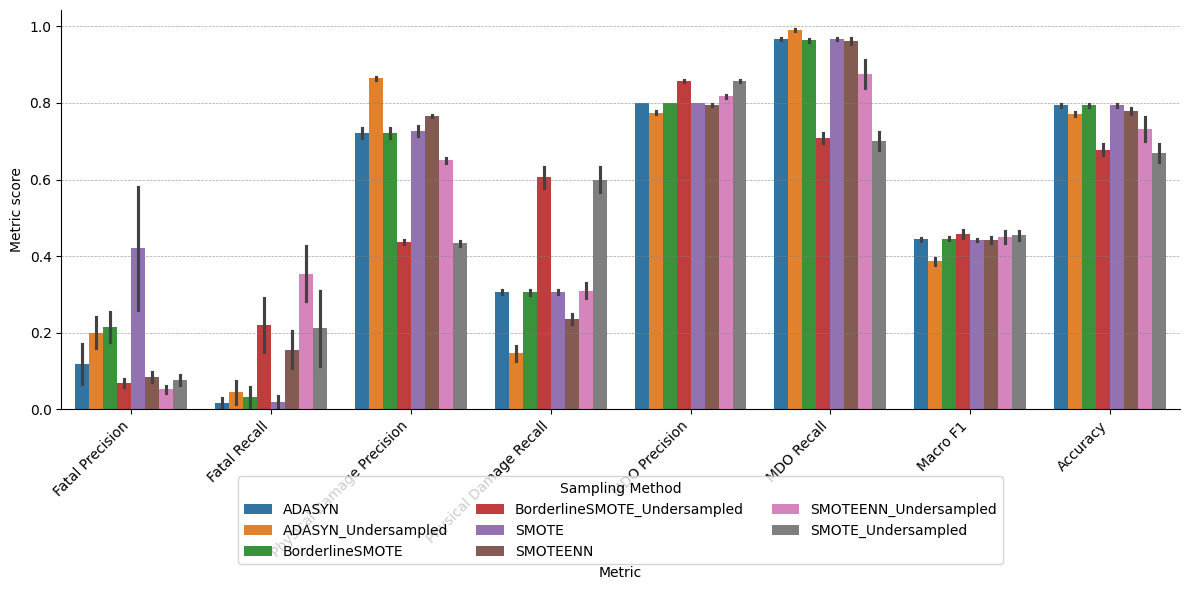

In [106]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted,
    x='Metric',
    y='Score',
    hue='Method',  
    errorbar='se'  # Standard error for APA transparency
)

plt.xlabel('Metric')
plt.ylabel('Metric score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sampling Method', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)


# ✅ Add horizontal gridlines for readability
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# ✅ Remove top and right spines (cleaner, APA style)
sns.despine()

plt.tight_layout()
plt.savefig('resampling_visualized', dpi = 300)
plt.show()


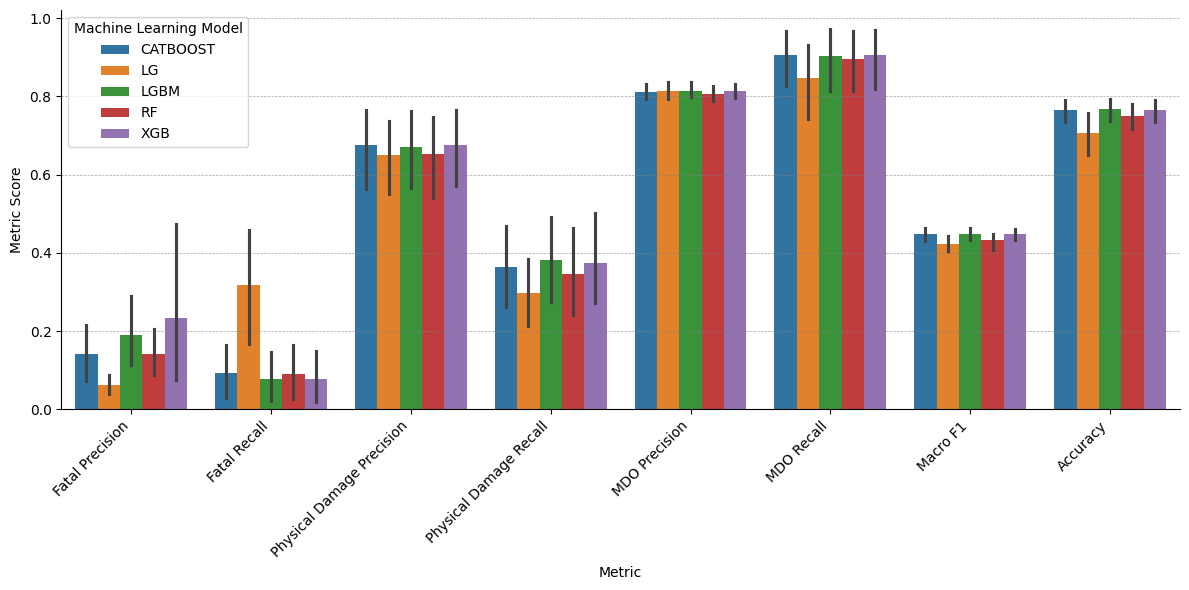

In [107]:
# barplot Metric/Model

plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Metric', y='Score', hue='name', errorbar='ci')

plt.xlabel('Metric')
plt.ylabel('Metric Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Machine Learning Model')

# Add subtle horizontal gridlines
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Remove top and right spines for cleaner look
sns.despine()

plt.tight_layout()
plt.savefig('model_visualized', dpi = 300)
plt.show()


#### Model Selection >>> 95%

In [17]:
# lower ci bound Resampling technique
def composite_and_sharpe(df, weight_mean=0.7, weight_std=0.3, n_folds=8):
    """
    Given df with column 'f1_macro',
    returns a DataFrame with:
      - mean_f1            : mean of f1_macro across folds
      - std_f1             : std of f1_macro across folds
      - lcb_95_confidence  : lower 95% confidence bound = mean_f1 - 1.96*std_f1/sqrt(n_folds)
    """
    # 1) aggregate
    stats = (
        df['Macro F1']
          .groupby(level=['name'])
          .agg(mean_f1='mean', std_f1='std')
    )

    # 2) lower 95% confidence bound
    stats['lcb_95_confidence'] = (
        stats['mean_f1']
      - 1.96 * stats['std_f1'] / np.sqrt(n_folds)
    )
    return stats

composite_and_sharpe(grouped).sort_values('lcb_95_confidence')

,mean_f1,std_f1,lcb_95_confidence
name,,,
LG,0.42375,0.030677,0.402492
RF,0.43250,0.034538,0.408567
XGB,0.44750,0.023755,0.431039
LGBM,0.44875,0.024165,0.432005
CATBOOST,0.44875,0.023566,0.432420


#### Resampling Selection 95%

In [18]:
# lower ci bound Model
def lower_ci_bound(df, n_folds=8):
    """
    Given df with column 'f1_macro',
    returns a DataFrame with:
      - mean_f1            : mean of f1_macro across folds
      - std_f1             : std of f1_macro across folds
      - lcb_95_confidence  : lower 95% confidence bound = mean_f1 - 1.96*std_f1/sqrt(n_folds)
    """
    # 1) aggregate
    stats = (
        df['Macro F1']
          .groupby(level=['Method'])
          .agg(mean_f1='mean', std_f1='std')
    )
    
    # 2) lower 95% confidence bound
    stats['lcb_95_confidence'] = (
        stats['mean_f1']
      - 1.96 * stats['std_f1'] / np.sqrt(n_folds)
    )
    return stats

lower_ci_bound(grouped).sort_values('lcb_95_confidence')

,mean_f1,std_f1,lcb_95_confidence
Method,,,
ADASYN_Undersampled,0.386,0.021909,0.370818
SMOTEENN_Undersampled,0.450,0.034641,0.425995
SMOTEENN,0.442,0.016432,0.430613
SMOTE_Undersampled,0.454,0.026077,0.435930
ADASYN,0.444,0.008944,0.437802
SMOTE,0.442,0.004472,0.438901
BorderlineSMOTE,0.446,0.008944,0.439802
BorderlineSMOTE_Undersampled,0.458,0.021679,0.442977


# Resampling strategy

In [232]:
X_train_encoded, y_train_100m, X_val_encoded, y_val_100m = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/train_val_enc')

In [253]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
import pandas as pd
import numpy as np

def optimize_bl_smote_rus_lgbm(X_train, y_train, X_test, y_test, label='DOD', n_trials=30):
    # Label encode y
    le = LabelEncoder()
    le.fit(['DOD', 'LET', 'UMS'])
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)

    # Fill missing values
    X_train = pd.DataFrame(X_train).fillna(0).values
    X_test = pd.DataFrame(X_test).fillna(0).values

    # Determine max class sizes for safe undersampling
    class_counts = Counter(y_train)
    other_labels = [lbl for lbl in class_counts if lbl != label]

    def objective(trial):
        # Suggest resampling targets
        smote_target = trial.suggest_int("bl_smote_target", 10000, 35000)
        rus_1 = trial.suggest_int("rus_1", 10000, 40000)
        rus_2 = trial.suggest_int("rus_2", 10000, 47000)

        # Build sampling strategies using label names
        over = {label: smote_target}
        under = {
            other_labels[0]: rus_1,
            other_labels[1]: rus_2
        }

        # Encode strategy keys to match encoded labels
        over_enc = {le.transform([k])[0]: v for k, v in over.items()}
        under_enc = {le.transform([k])[0]: v for k, v in under.items()}

        # Build pipeline
        pipe = ImbPipeline([
            ('blsmote', BorderlineSMOTE(sampling_strategy=over_enc, random_state=42)),
            ('rus', RandomUnderSampler(sampling_strategy=under_enc, random_state=42)),
            ('lgbm', LGBMClassifier(
                objective='multiclass',
                num_class=3,
                n_estimators=150,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1,
                verbose=-1
            ))
        ])

        return cross_val_score(
            pipe, X_train, y_train_enc,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring=make_scorer(f1_score, average='macro'),
            error_score='raise'
        ).mean()

    # Run Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print(f"\n✅ Best parameters: {study.best_params} — Macro F1: {study.best_value:.4f}")

    # Retrain best pipeline on full training data
    best = study.best_params
    final_over = {label: best["bl_smote_target"]}
    final_under = {
        other_labels[0]: best["rus_1"],
        other_labels[1]: best["rus_2"]
    }
    over_enc = {le.transform([k])[0]: v for k, v in final_over.items()}
    under_enc = {le.transform([k])[0]: v for k, v in final_under.items()}

    final_pipe = ImbPipeline([
        ('blsmote', BorderlineSMOTE(sampling_strategy=over_enc, random_state=42)),
        ('rus', RandomUnderSampler(sampling_strategy=under_enc, random_state=42)),
        ('lgbm', LGBMClassifier(
            objective='multiclass',
            num_class=3,
            n_estimators=150,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ))
    ])

    final_pipe.fit(X_train, y_train_enc)

    # Evaluate on test set
    y_pred = final_pipe.predict(X_test)
    print("\n=== Final Test Set Report ===")
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
    print(confusion_matrix(y_test_enc, y_pred))

    return final_pipe, study


In [254]:
optimize_bl_smote_rus_lgbm(X_train_encoded, y_train_100m, X_val_encoded, y_val_100m)

[I 2025-05-13 18:46:19,331] A new study created in memory with name: no-name-b226516a-680a-4b83-9333-6cb1ea1d8e31
[I 2025-05-13 18:46:36,762] Trial 0 finished with value: 0.479879074933039 and parameters: {'bl_smote_target': 16527, 'rus_1': 36493, 'rus_2': 20810}. Best is trial 0 with value: 0.479879074933039.
[I 2025-05-13 18:46:56,441] Trial 1 finished with value: 0.48078390478671135 and parameters: {'bl_smote_target': 32641, 'rus_1': 35158, 'rus_2': 21878}. Best is trial 1 with value: 0.48078390478671135.
[I 2025-05-13 18:47:14,281] Trial 2 finished with value: 0.4846412978967364 and parameters: {'bl_smote_target': 22292, 'rus_1': 25474, 'rus_2': 19304}. Best is trial 2 with value: 0.4846412978967364.
[I 2025-05-13 18:47:33,177] Trial 3 finished with value: 0.4785429669877493 and parameters: {'bl_smote_target': 22215, 'rus_1': 38592, 'rus_2': 24307}. Best is trial 2 with value: 0.4846412978967364.
[I 2025-05-13 18:47:53,692] Trial 4 finished with value: 0.4619537544863882 and parame


✅ Best parameters: {'bl_smote_target': 28611, 'rus_1': 22151, 'rus_2': 13457} — Macro F1: 0.4905

=== Final Test Set Report ===
              precision    recall  f1-score   support

         DOD       0.08      0.11      0.10       699
         LET       0.56      0.45      0.50     19585
         UMS       0.83      0.88      0.85     58738

    accuracy                           0.77     79022
   macro avg       0.49      0.48      0.48     79022
weighted avg       0.76      0.77      0.76     79022

[[   76   271   352]
 [  361  8849 10375]
 [  463  6640 51635]]


(Pipeline(steps=[('blsmote',
                  BorderlineSMOTE(random_state=42,
                                  sampling_strategy={np.int64(0): 28611})),
                 ('rus',
                  RandomUnderSampler(random_state=42,
                                     sampling_strategy={np.int64(1): 13457,
                                                        np.int64(2): 22151})),
                 ('lgbm',
                  LGBMClassifier(n_estimators=150, n_jobs=-1, num_class=3,
                                 objective='multiclass', random_state=42,
                                 verbose=-1))]),
 <optuna.study.study.Study at 0x5953bc850>)

In [278]:
import optuna
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

# Fixed resampling settings
bl_smote_target = 28611
rus_1 = 13457
rus_2 = 22151

# Encode labels
le = LabelEncoder()
le.fit(['DOD', 'LET', 'UMS'])

# Shuffle the training data
X_train_shuffled, y_train_shuffled = shuffle(
    X_train_encoded, y_train_100m, random_state=42
)

y_train_enc = le.transform(y_train_shuffled)
y_val_enc   = le.transform(y_val_100m)

# Define target/other class names
target_label = 'DOD'
other_labels = [lbl for lbl in le.classes_ if lbl != target_label]

# Create resampling strategies (encoded)
over_enc = {le.transform([target_label])[0]: bl_smote_target}
under_enc = {
    le.transform([other_labels[0]])[0]: rus_1,
    le.transform([other_labels[1]])[0]: rus_2
}

# Fill NaNs
X_train_filled = pd.DataFrame(X_train_shuffled).fillna(0).values
X_val_filled   = pd.DataFrame(X_val_encoded).fillna(0).values

# Define Optuna objective
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    pipeline = ImbPipeline([
        ('blsmote', BorderlineSMOTE(sampling_strategy=over_enc, random_state=42)),
        ('rus', RandomUnderSampler(sampling_strategy=under_enc, random_state=42)),
        ('lgbm', LGBMClassifier(**params))
    ])

    score = cross_val_score(
        pipeline,
        X_train_filled,
        y_train_enc,
        cv=StratifiedKFold(n_splits=8, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score, average='macro'),
        error_score='raise'
    ).mean()

    return score

# Run Optuna tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Show best trial
print(f"\n✅ Best Hyperparameters: {study.best_params}")
print(f"✅ Best Macro F1: {study.best_value:.4f}")

# Train final model on full training set using best params
best_params = study.best_params
best_params.update({
    'objective': 'multiclass',
    'num_class': 3,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
})

final_pipeline = ImbPipeline([
    ('blsmote', BorderlineSMOTE(sampling_strategy=over_enc, random_state=42)),
    ('rus', RandomUnderSampler(sampling_strategy=under_enc, random_state=42)),
    ('lgbm', LGBMClassifier(**best_params))
])

final_pipeline.fit(X_train_filled, y_train_enc)
y_pred = final_pipeline.predict(X_val_filled)

# Final evaluation
print("\n=== Final Evaluation on Validation Set ===")
print(classification_report(y_val_enc, y_pred, target_names=le.classes_))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_enc, y_pred))


[I 2025-05-13 20:41:30,161] A new study created in memory with name: no-name-0215b7df-c9ff-44de-ac80-5cbdd4b8a60f
[I 2025-05-13 20:41:46,982] Trial 0 finished with value: 0.4907841861768847 and parameters: {'n_estimators': 78, 'learning_rate': 0.13815645019437084, 'max_depth': 6, 'min_child_samples': 32, 'subsample': 0.6878559071595371, 'colsample_bytree': 0.7448012774859325, 'reg_alpha': 0.24262694252554806, 'reg_lambda': 0.12127769119272536}. Best is trial 0 with value: 0.4907841861768847.
[I 2025-05-13 20:42:04,537] Trial 1 finished with value: 0.4909768170115586 and parameters: {'n_estimators': 104, 'learning_rate': 0.10926060921192161, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.5057792073510077, 'colsample_bytree': 0.9414085395963909, 'reg_alpha': 1.7991969498933598, 'reg_lambda': 1.5276164609367855}. Best is trial 1 with value: 0.4909768170115586.
[I 2025-05-13 20:42:17,430] Trial 2 finished with value: 0.4867701766914818 and parameters: {'n_estimators': 84, 'learnin


✅ Best Hyperparameters: {'n_estimators': 150, 'learning_rate': 0.13970161912980927, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.8441167442022469, 'colsample_bytree': 0.5840385613745391, 'reg_alpha': 0.790008258804648, 'reg_lambda': 0.7444711000801812}
✅ Best Macro F1: 0.4929

=== Final Evaluation on Validation Set ===
              precision    recall  f1-score   support

         DOD       0.09      0.10      0.10       699
         LET       0.55      0.46      0.50     19585
         UMS       0.83      0.87      0.85     58738

    accuracy                           0.76     79022
   macro avg       0.49      0.48      0.48     79022
weighted avg       0.75      0.76      0.76     79022

=== Confusion Matrix ===
[[   69   269   361]
 [  301  9105 10179]
 [  361  7220 51157]]
